In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./dataset/dataset/transfers.csv')
dataset = df[df['dir'] == 'in']
dataset

,league,season,window,team_id,team_name,team_country,dir,player_id,player_name,player_age,...,counter_team_id,counter_team_name,counter_team_country,transfer_fee_amnt,market_val_amnt,is_free,is_loan,is_loan_end,is_retired,transfer_id
0,GB1,2009,s,985,Manchester United,England,in,33544,Antonio Valencia,23.0,...,1071,Wigan Athletic,England,18800000.0,NaN,False,False,False,False,310832
1,GB1,2009,s,985,Manchester United,England,in,62049,Mame Diouf,21.0,...,687,Molde FK,Norway,4500000.0,1600000.0,False,False,False,False,319841
2,GB1,2009,s,985,Manchester United,England,in,43261,Gabriel Obertan,20.0,...,40,FC Girondins Bordeaux,France,4000000.0,400000.0,False,False,False,False,315185
3,GB1,2009,s,985,Manchester United,England,in,1397,Michael Owen,29.0,...,762,Newcastle United,England,0.0,NaN,True,False,False,False,306421
4,GB1,2009,s,985,Manchester United,England,in,73538,Scott Moffatt,18.0,...,5242,Manchester United U18,England,NaN,NaN,False,False,False,False,339015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70000,NL1,2021,w,385,Fortuna Sittard,Netherlands,in,140032,Andreas Samaris,32.0,...,515,Without Club,Without Club,NaN,1500000.0,False,False,False,False,3633188
70001,NL1,2021,w,306,SC Heerenveen,Netherlands,in,257808,Runar Espejord,25.0,...,1293,Tromsø IL,Norway,NaN,500000.0,False,True,True,False,3071862
70002,NL1,2021,w,306,SC Heerenveen,Netherlands,in,580142,Joaquín Fernández,22.0,...,37535,Montevideo City Torque,Uruguay,NaN,100000.0,False,True,True,False,3268245
70003,NL1,2021,w,468,Sparta Rotterdam,Netherlands,in,340353,Maduka Okoye,22.0,...,1010,Watford FC,England,NaN,1000000.0,False,True,False,False,3619917


In [3]:
# rimuovi i 6 player che non hanno età
dataset.dropna(subset=['player_age'], inplace=True)
# sostituisci i valori di trasferimento Nan con 0
dataset['transfer_fee_amnt'].fillna(0, inplace=True)
# sostituisci i valori di valore di mercato Nan con 0
dataset['market_val_amnt'].fillna(0, inplace=True)
# rimuovi i trasferimenti senza squadra di destinazione (ovvero svincoli)
dataset = dataset[dataset['counter_team_name'] != 'Without Club'] 
# rimuovi i trasferimenti senza squadra di provenienza (ovvero ingaggio di svincolati)
dataset = dataset[dataset['team_name'] != 'Without Club']
# Rimuovi le righe in cui 'team_id' o 'counter_team_id' sono uguali a 'Retired'
dataset = dataset[(dataset['team_id'] != 'Retired') & (dataset['counter_team_id'] != 'Retired')]
# Rimozione dei rientri dal prestito (is_loan_end = True)
dataset = dataset[dataset['is_loan_end'] == False]

# Conversione dei valori di 'team_id' e 'counter_team_id' in interi
dataset['team_id'] = dataset['team_id'].astype(int)
dataset['counter_team_id'] = dataset['counter_team_id'].astype(int)


print('Il dataset è composto da ', dataset.shape[0], ' trasferimenti')

Il dataset è composto da  22696  trasferimenti


/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1319/3190214965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(subset=['player_age'], inplace=True)
/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1319/3190214965.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['transfer_fee_amnt'].fillna(0, inplace=True)
/var/folders/61/9rphml817c1d45n8g26p1ltm0000gn/T/ipykernel_1319/3190214965.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [4]:
G = nx.MultiDiGraph()

for index, row in dataset.iterrows():
    player_name = row['player_name']
    
    # Utilizza l'ID della squadra come identificatore del nodo
    team1 = row['team_id']
    team2 = row['counter_team_id']
    
    if not G.has_node(team1):
        G.add_node(team1, label='team', name=row['team_name'], country=row['team_country'])
    if not G.has_node(team2):
        G.add_node(team2, label='team', name=row['counter_team_name'], country=row['counter_team_country'])
    
    transfer_attributes = {
        'transfer_id': row['transfer_id'],
        'player_id': row['player_id'],
        'player_name': row['player_name'],
        'player_age': row['player_age'],
        'season': row['season'],
        'window': row['window'],
        'transfer_fee_amnt': row['transfer_fee_amnt'],
        'is_loan': row['is_loan'],
        'market_val_amnt': row['market_val_amnt']
    }
    
    G.add_edge(team2, team1, label='transfer', **transfer_attributes) 

print('Numero di nodi:', G.number_of_nodes())
print('Numero di archi:', G.number_of_edges())


Numero di nodi: 2193
Numero di archi: 22696


In [5]:
# Calcola il grado dei nodi in ingresso e in uscita
in_degree = G.in_degree()
out_degree = G.out_degree()

# Crea un elenco dei nodi (team) che soddisfano il criterio di avere almeno un arco in ingresso e uno in uscita 
selected_teams = [node for node in G.nodes() if out_degree[node] > 0 and in_degree[node] > 0 ] 

print('Nodi selezionati -> ', len(selected_teams), ' nodi con almeno 10 operazioni di mercato')

# Crea un nuovo grafo (sottografo) basato sui nodi selezionati
net = G.subgraph(selected_teams)

net = net.copy()

# Identifica i nodi che soddisfano il criterio (transfer_fee_amnt uguale a 0 per tutti gli archi uscenti e entranti)
nodes_to_remove = []
for node in net.nodes():
    out_edges = net.out_edges(node, data=True)
    in_edges = net.in_edges(node, data=True)
        
    if all(attr['transfer_fee_amnt'] == 0 for _, _, attr in out_edges) and all(attr['transfer_fee_amnt'] == 0 for _, _, attr in in_edges):
        nodes_to_remove.append(node)

print('Nodi da rimuovere -> ', len(nodes_to_remove), ' nodi con tutte le operazioni di mercato a 0')

net.remove_nodes_from(nodes_to_remove)

print('Nodi -> ', net.number_of_nodes())
print('Archi -> ', net.number_of_edges())
print('Density -> ', nx.density(net))

Nodi selezionati ->  239  nodi con almeno 10 operazioni di mercato
Nodi da rimuovere ->  3  nodi con tutte le operazioni di mercato a 0
Nodi ->  236
Archi ->  11648
Density ->  0.21002524341868012


/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default 

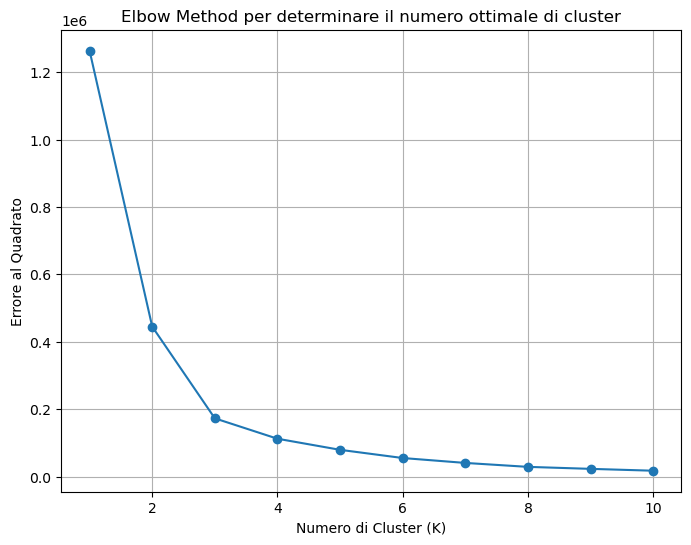

In [33]:
###### CALCOLO DEL K MIGLIORE ######

from sklearn.cluster import KMeans
import numpy as np

# Ottieni il grafo dei nodi
degrees = dict(net.degree())

# Estrai i gradi in una lista per usarli nel K-Means
degree_values = list(degrees.values())

# Inizializza una lista vuota per memorizzare l'errore al quadrato
inertia = []

# Esegui K-Means per un intervallo di valori di K
for k in range(1, 11):  # Prova da 1 a 10 cluster
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(np.array(degree_values).reshape(-1, 1))
    inertia.append(kmeans.inertia_)

# Disegna il grafico dell'errore al quadrato in funzione di K
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Numero di Cluster (K)')
plt.ylabel('Errore al Quadrato')
plt.title('Elbow Method per determinare il numero ottimale di cluster')
plt.grid()
plt.show()

/Users/manuelplacella/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


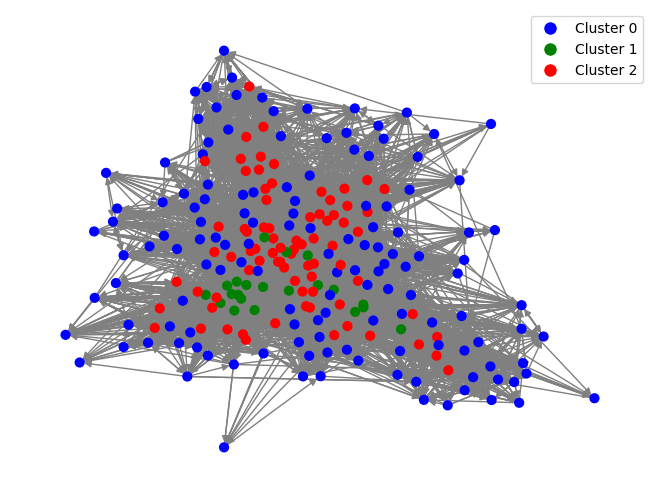

In [40]:


# Ottieni il grafo dei nodi 
degrees = dict(net.degree())

# Estrai i gradi in una lista per usarli nel kmeans
degree_values = list(degrees.values())

# Esegui il kmeans con 3 cluster
kmeans = KMeans(n_clusters=3)

# Addestra il modello utilizzando la lista di gradi
kmeans.fit(np.array(degree_values).reshape(-1, 1))

# Ottieni le etichette dei cluster per ogni nodo
cluster_labels = kmeans.labels_

# Aggiungi le etichette dei cluster come attributo ai nodi
for node, label in zip(net.nodes(), cluster_labels):
    net.nodes[node]['cluster'] = label

#################  Rappresentazione del grafo  #################

# Definisci una lista di colori per i cluster
cluster_colors = ['b', 'g', 'r']

# Crea un dizionario che mappa i cluster alle rispettive etichette dei colori
cluster_color_mapping = {cluster: color for cluster, color in enumerate(cluster_colors)}

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Crea una lista di colori per ogni nodo basata sui cluster
node_colors = [cluster_color_mapping[cluster_labels[node]] for node in net.nodes()]

# Disegna il grafo utilizzando i colori dei nodi
pos = nx.spring_layout(net)  # Puoi utilizzare un layout diverso se preferisci
nx.draw(net, pos, node_color=node_colors, with_labels=False, node_size=40, edge_color='grey')

# Aggiungi una legenda ai colori dei cluster
legend_labels = [f'Cluster {cluster}' for cluster in range(len(cluster_colors))]
legend_colors = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, cluster_colors)]
plt.legend(handles=legend_colors)

# Mostra il grafico
plt.show()

In [36]:
# Definisci il numero del cluster da cui desideri ottenere i nodi
cluster_to_print = 0

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Inizializza variabili per calcolare il numero totale di trasferimenti e il numero di nodi nel cluster
total_transfers = 0
num_nodes_in_cluster = 0

# Itera attraverso i nodi nel cluster desiderato e stampa l'ID, il nome e il numero di trasferimenti
for node in net.nodes():
    if cluster_labels[node] == cluster_to_print:
        num_nodes_in_cluster += 1
        total_transfers += net.degree(node)
        node_id = node
        node_name = net.nodes[node]['name']
        num_transfers = net.degree(node)
        print(f'ID: {node_id}, Nome: {node_name}, Numero di Trasferimenti: {num_transfers}')

# Calcola il numero medio di trasferimenti
average_transfers = total_transfers / num_nodes_in_cluster

# Stampa il numero medio di trasferimenti
print(f'\nNumero Medio di Trasferimenti nel Cluster: {average_transfers}')


ID: 2, Nome: 1.FC Kaiserslautern, Numero di Trasferimenti: 39
ID: 3, Nome: 1. FC Köln, Numero di Trasferimenti: 86
ID: 4, Nome: 1.FC Nuremberg, Numero di Trasferimenti: 58
ID: 4102, Nome: Carpi FC 1909, Numero di Trasferimenti: 41
ID: 1032, Nome: Reading FC, Numero di Trasferimenti: 35
ID: 10, Nome: Arminia Bielefeld, Numero di Trasferimenti: 22
ID: 1039, Nome: Queens Park Rangers, Numero di Trasferimenti: 73
ID: 18, Nome: Borussia Mönchengladbach, Numero di Trasferimenti: 89
ID: 19, Nome: Brescia Calcio, Numero di Trasferimenti: 51
ID: 23, Nome: Eintracht Braunschweig, Numero di Trasferimenti: 11
ID: 543, Nome: Wolverhampton Wanderers, Numero di Trasferimenti: 84
ID: 12321, Nome: Girona FC, Numero di Trasferimenti: 42
ID: 35, Nome: FC St. Pauli, Numero di Trasferimenti: 14
ID: 6692, Nome: Novara Calcio 1908, Numero di Trasferimenti: 37
ID: 38, Nome: Fortuna Düsseldorf, Numero di Trasferimenti: 44
ID: 42, Nome: Hannover 96, Numero di Trasferimenti: 81
ID: 1071, Nome: Wigan Athletic, Nu

In [37]:
# Definisci il numero del cluster da cui desideri ottenere i nodi
cluster_to_print = 1

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Inizializza variabili per calcolare il numero totale di trasferimenti e il numero di nodi nel cluster
total_transfers = 0
num_nodes_in_cluster = 0

# Itera attraverso i nodi nel cluster desiderato e stampa l'ID, il nome e il numero di trasferimenti
for node in net.nodes():
    if cluster_labels[node] == cluster_to_print:
        num_nodes_in_cluster += 1
        total_transfers += net.degree(node)
        node_id = node
        node_name = net.nodes[node]['name']
        num_transfers = net.degree(node)
        print(f'ID: {node_id}, Nome: {node_name}, Numero di Trasferimenti: {num_transfers}')

# Calcola il numero medio di trasferimenti
average_transfers = total_transfers / num_nodes_in_cluster

# Stampa il numero medio di trasferimenti
print(f'\nNumero Medio di Trasferimenti nel Cluster: {average_transfers}')


ID: 5, Nome: AC Milan, Numero di Trasferimenti: 292
ID: 12, Nome: AS Roma, Numero di Trasferimenti: 310
ID: 13, Nome: Atlético de Madrid, Numero di Trasferimenti: 221
ID: 1038, Nome: UC Sampdoria, Numero di Trasferimenti: 275
ID: 1049, Nome: Valencia CF, Numero di Trasferimenti: 221
ID: 46, Nome: FC Internazionale, Numero di Trasferimenti: 351
ID: 6195, Nome: SSC Napoli, Numero di Trasferimenti: 241
ID: 1075, Nome: SC Braga, Numero di Trasferimenti: 255
ID: 631, Nome: Chelsea FC, Numero di Trasferimenti: 270
ID: 130, Nome: Parma Calcio 1913, Numero di Trasferimenti: 310
ID: 162, Nome: AS Monaco, Numero di Trasferimenti: 243
ID: 720, Nome: FC Porto, Numero di Trasferimenti: 285
ID: 252, Nome: Genoa CFC, Numero di Trasferimenti: 436
ID: 281, Nome: Manchester City, Numero di Trasferimenti: 221
ID: 800, Nome: Atalanta BC, Numero di Trasferimenti: 233
ID: 294, Nome: SL Benfica, Numero di Trasferimenti: 277
ID: 336, Nome: Sporting CP, Numero di Trasferimenti: 244
ID: 368, Nome: Sevilla FC, N

In [38]:
# Definisci il numero del cluster da cui desideri ottenere i nodi
cluster_to_print = 2

# Estrai gli attributi dei cluster dai nodi
cluster_labels = nx.get_node_attributes(net, 'cluster')

# Inizializza variabili per calcolare il numero totale di trasferimenti e il numero di nodi nel cluster
total_transfers = 0
num_nodes_in_cluster = 0

# Itera attraverso i nodi nel cluster desiderato e stampa l'ID, il nome e il numero di trasferimenti
for node in net.nodes():
    if cluster_labels[node] == cluster_to_print:
        num_nodes_in_cluster += 1
        total_transfers += net.degree(node)
        node_id = node
        node_name = net.nodes[node]['name']
        num_transfers = net.degree(node)
        print(f'ID: {node_id}, Nome: {node_name}, Numero di Trasferimenti: {num_transfers}')

# Calcola il numero medio di trasferimenti
average_transfers = total_transfers / num_nodes_in_cluster

# Stampa il numero medio di trasferimenti
print(f'\nNumero Medio di Trasferimenti nel Cluster: {average_transfers}')


ID: 512, Nome: Stoke City, Numero di Trasferimenti: 104
ID: 1025, Nome: Bologna FC 1909, Numero di Trasferimenti: 194
ID: 11, Nome: Arsenal FC, Numero di Trasferimenti: 164
ID: 16, Nome: Borussia Dortmund, Numero di Trasferimenti: 133
ID: 1041, Nome: Olympique Lyon, Numero di Trasferimenti: 143
ID: 15, Nome: Bayer 04 Leverkusen, Numero di Trasferimenti: 135
ID: 533, Nome: TSG 1899 Hoffenheim, Numero di Trasferimenti: 146
ID: 24, Nome: Eintracht Frankfurt, Numero di Trasferimenti: 136
ID: 1050, Nome: Villarreal CF, Numero di Trasferimenti: 172
ID: 27, Nome: Bayern Munich, Numero di Trasferimenti: 130
ID: 29, Nome: Everton FC, Numero di Trasferimenti: 128
ID: 31, Nome: Liverpool FC, Numero di Trasferimenti: 168
ID: 33, Nome: FC Schalke 04, Numero di Trasferimenti: 175
ID: 39, Nome: 1.FSV Mainz 05, Numero di Trasferimenti: 136
ID: 40, Nome: FC Girondins Bordeaux, Numero di Trasferimenti: 122
ID: 41, Nome: Hamburger SV, Numero di Trasferimenti: 119
ID: 44, Nome: Hertha BSC, Numero di Trasf